In [1]:
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
from ChromoGen import Conformations
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import torch

plt.style.use('../support/plot_style.txt')

2024-11-21 17:38:21.660460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prep

Paths

In [2]:
pdf_dir = Path('./pdfs/')
cgen_conformations_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878/chrom_22/'
formatted_dipc_data = '../../downloaded_data/conformations/DipC/processed_data.h5'
temp_data_dir = './calc_results/'

# To parallelize data loading/coordinate centering via ThreadPoolExecutor. 
# If you aren't on a distributed system, probably want max_workers=1 or the 
# file requests may slow down your data reads. 
# The bulk of the computation isn't parallelized BY ME since it happens on the CPU
# (relatively few cores) using MDTraj, WHICH ALREADY PARALLELIZES across all the available cores.
max_workers = None

# Note: Not giving high-precision/gpu params because MDTraj doesn't work with either. 
# However, coordinates will be centered with double precision prior to MDTraj computations. 

Format paths

In [3]:
# data directories. Likely to exist if you cloned the repo. 
cgen_conformations_dir = Path(cgen_conformations_dir)
assert cgen_conformations_dir.exists()

formatted_dipc_data = Path(formatted_dipc_data)
assert formatted_dipc_data.exists()

temp_data_dir = Path(temp_data_dir)
temp_data_dir.mkdir(exist_ok=True,parents=True)

if max_workers is not None:
    assert isinstance(max_workers,int) and max_workers > 0

pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True,parents=True)

if (fn:=cgen_conformations_dir.name)[:6] == 'chrom_':
    chroms = [fn.split('_')[-1]]
else:
    chroms = None

Initialize Dip-C dataset

In [4]:
config_ds = ConfigDataset(
    str(formatted_dipc_data),
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False, 
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=chroms, 
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

## Compute statistics

#### Support

This will be run in parallel since IO is a significant factor in time to run this script

In [5]:
def load_and_center_conformations(f):

    ###
    # Infer chromosome, start_idx from the filepath
    chrom = f.parent.name.split('_')[-1]
    start_idx = int(f.name.split('_')[2]) * 1000

    ### 
    # Dip-C 
    
    # Grab the Dip-C conformations (which are techincally already in memory but
    # must be parsed) and info about which cell, replicate, etc., 
    # maternal/paternal chromosome, etc., they come from
    info_df, coords = config_ds.fetch_specific_coords(chrom,start_idx)

    # Remove replicates, which may otherwise bias the results
    observed_chroms = []
    rows_to_use = []
    for i,row in info_df.iterrows():
        info = (row.Cell,row.Lineage)
        if info in observed_chroms:
            continue
        observed_chroms.append(info)
        rows_to_use.append(i)
    
    dipc_conformations = Conformations(coords[rows_to_use,...])
    
    # Load/concatenate all the ChromoGen-inferred conformations
    f2 = cgen_conformations_dir / f'start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'
    f1 = cgen_conformations_dir / f'start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'
    cgen_conformations = Conformations(f1).cat(Conformations(f2)).double_()

    # Center coordinates
    dipc_conformations = dipc_conformations.center_coordinates()
    cgen_conformations = cgen_conformations.center_coordinates()

    # Return on CPU & with single precision, which isn't technically necessary since the 
    # Conformations subclasses handle this dynamically, but it avoids the associated overhead.
    return cgen_conformations.float_().cpu_(), dipc_conformations.float_().cpu_()

This function does all the work.

In [6]:
def rmsd_calc_one_region(
    cgen_conformations,
    dipc_conformations,
    cgen_conformations_dir = cgen_conformations_dir,
    config_ds = config_ds
):

    # Compute all pairwise RMSD values
    rmsds = []
    for reference in dipc_conformations:
        # Superpose the ChromoGen-inferred conformations onto the reference
        # Clone the true coordinates since this happens in-place. 
        # Note that while I believe MDTraj.rmsd does this step automatically, 
        # I am doing it separately here for good measure. 
        cgen = cgen_conformations.clone().superpose(reference, use_mdtraj = True)

        # RMSD calculation
        rmsds.append(cgen.rmsd(reference, use_mdtraj = True))

    # Stacking on dimension 0 makes dimensions (dipc index, cgen index)
    rmsds = torch.stack(rmsds,dim=0)

    # For conformations containing NaNs, MDTraj gives us a zero-valued RMSD.
    # That's obviously wrong, so replace them with NaNs
    rmsds[:,cgen.values.isnan().any(-1).any(-1)] = torch.nan
    
    return rmsds

### Compute the results

#### Pairwise RMSDs (Dip-C vs ChromoGen) within each region

In [7]:
result_fp = temp_data_dir / 'rmsd_results.pt'

if False: #result_fp.exists():
    rmsds = torch.load(result_fp)
else:

    # Iterate over files associated with one set of guidance parameters to avoid
    # computing the same data multiple times. 
    files = list(cgen_conformations_dir.rglob('*cond_scale_1.0_rescaled_phi_0.0.pt'))
    files.sort() # makes it easier to analyze specific datapoints later (if desired).
    
    # So that we can submit computations before all data is loaded 
    # but also don't run into issues where already-parallel MDTraj
    # computations conflict with each other
    executor1 = ThreadPoolExecutor(max_workers=1) 
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        load_futures = [
            executor.submit(load_and_center_conformations,f)
            for f in files
        ]
        compute_futures = []

        for future in tqdm(load_futures,desc='Load progress'):
            compute_futures.append(
                executor1.submit(rmsd_calc_one_region,*future.result())
            )
    
    rmsds = []
    for future in tqdm(compute_futures,desc='Compute progress'):
        rmsds.append(future.result())

    rmsds = torch.cat(rmsds,dim=0)
        
    executor1.shutdown()

    torch.save({'rmsds':rmsds}, result_fp)

# Convert to nm
rmsds*= 100

Load progress:   0%|          | 0/32 [00:00<?, ?it/s]

Compute progress:   0%|          | 0/32 [00:00<?, ?it/s]

#### Pairwise RMSDs (Dip-C vs ChromoGen) throughout the chromosome

This one takes a while...

In [8]:
result_fp = temp_data_dir / 'rmsd_results_across_chromosome.pt'

if result_fp.exists():
    rmsds_chromosome_wide = torch.load(result_fp)
else:

    # Iterate over files associated with one set of guidance parameters to avoid
    # computing the same data multiple times. 
    files = list(cgen_conformations_dir.rglob('*cond_scale_1.0_rescaled_phi_0.0.pt'))
    files.sort() # makes it easier to analyze specific datapoints later (if desired).

    # Load conformations
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        load_futures = [
            executor.submit(load_and_center_conformations,f)
            for f in files
        ]
        compute_futures = []

        cgen, dipc = [], []
        for future in tqdm(load_futures,desc='Load progress'):
            a,b = future.result()
            cgen.append(a)
            dipc.append(b)

    # Concatenate all the conformations
    cgen = cgen[0].append(cgen[1:])
    dipc = dipc[0].append(dipc[1:])

    # compute RMSD values
    rmsds_chromosome_wide = rmsd_calc_one_region(cgen,dipc)

    # Save
    torch.save(rmsds_chromosome_wide, result_fp)

# Convert to nm
rmsds_chromosome_wide*= 100

Load progress:   0%|          | 0/32 [00:00<?, ?it/s]

#### Compute the minimums & bin the data

Recall that dimensions are (Dip-C index, ChromoGen index), so we are finding the best ChromoGen-inferred structure for each Dip-C-inferred structure

In [9]:
bins = torch.arange(0,1001,5,dtype=torch.float)

# Conveniently, these functions ignore NaN values as-is when computing probability densities
all_rmsds = torch.histogram(rmsds.flatten(),bins,density=True).hist.cpu().numpy()
all_rmsds_chromosome_wide = torch.histogram(rmsds_chromosome_wide,bins,density=True).hist.cpu().numpy()

# PyTorch ~for some reason~ doesn't have an nanmin method. So, replace the NaN values with 
# something deeeefinitely larger than the minimums before taking minimums
rmsds[rmsds.isnan()] = 1_000_000_000
rmsds_chromosome_wide[rmsds_chromosome_wide.isnan()] = 1_000_000_000

# Bin the minimum values
min_rmsds = torch.histogram(rmsds.min(1).values,bins,density=True).hist.cpu().numpy()
min_rmsds_chromosome_wide = torch.histogram(rmsds_chromosome_wide.min(1).values,bins,density=True).hist.cpu().numpy()


bins = bins.numpy()

## Plot

Use the center of each bin as x-axis values. 

In [10]:
x = (bins[1:] + bins[:-1]) / 2

Make the figure 

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'M', 'P', 'R', 'S', 'a', 'b', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 42, 48, 51, 53, 54, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 41 glyphs after
INFO:fontTools

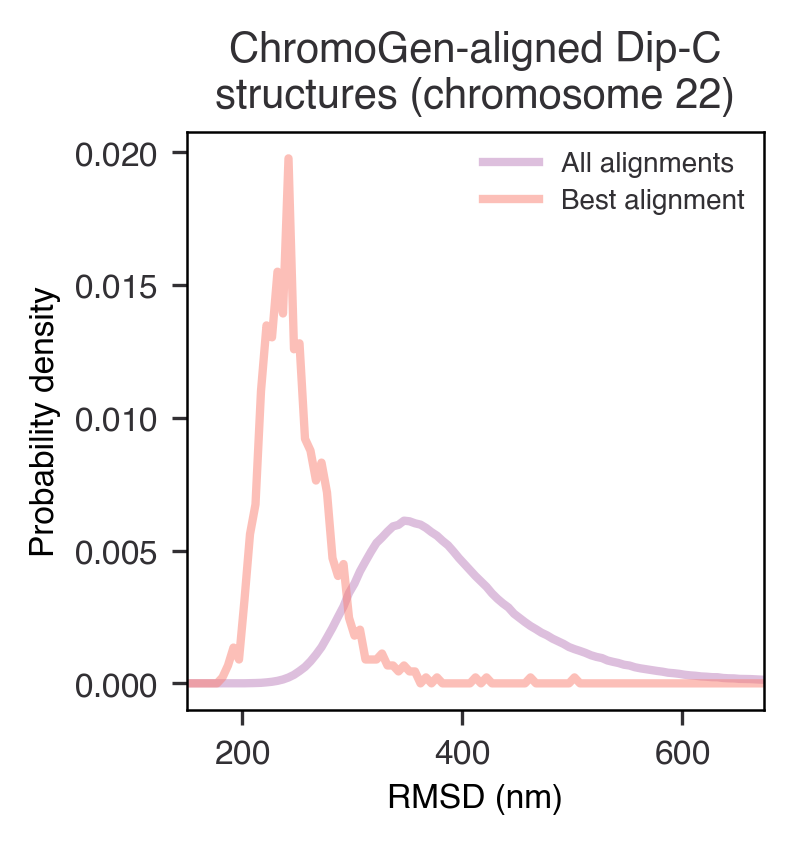

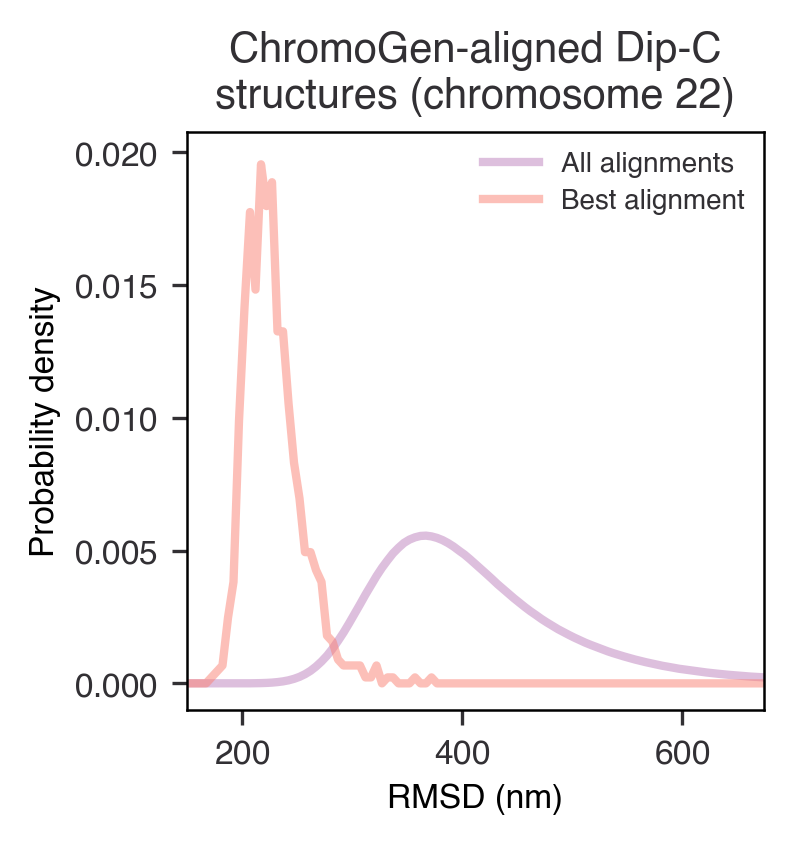

In [11]:
for rmsd_hist, rmsd_min_hist, fn in [
    (all_rmsds,min_rmsds,'rmsds_within_region'),
    (all_rmsds_chromosome_wide,min_rmsds_chromosome_wide,'rmsds_within_chromosome')
]:

    # Initialize
    fig = plt.figure(figsize=(2.5,2.5))
    ax = fig.add_subplot(111)
    
    # Plot the data
    ax.plot(x,rmsd_hist,alpha=.5,label='All alignments')
    ax.plot(x,rmsd_min_hist,alpha=.5,label='Best alignment')
    
    # Set limits
    xlim = [150,675]
    ax.set_xlim(xlim)
    ymax = max(all_rmsds.max(),min_rmsds.max())
    ylim = [-0.05 * ymax, 1.05 * ymax]
    ax.set_ylim(ylim)
    
    # Set various labels
    ax.set_title('ChromoGen-aligned Dip-C\nstructures (chromosome 22)')
    ax.set_xlabel('RMSD (nm)')
    ax.set_ylabel('Probability density')
    ax.legend(framealpha=0,fontsize='small')
    
    # Force the figure to be square
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    
    # Save
    fig.savefig( (pdf_dir / fn).with_suffix('.pdf'), transparent=True)